# NGIML Inference (Colab)
Load a trained checkpoint and run a sanity-check inference on one sample from the manifest.

In [1]:
import subprocess, sys
from pathlib import Path

REPO_URL = "https://github.com/DeogenesMaranan/ngiml"
REPO_DIR = Path("/content/ngiml")

if REPO_DIR.exists():
    subprocess.run(["git", "-C", str(REPO_DIR), "pull"], check=True)
else:
    subprocess.run(["git", "clone", REPO_URL, str(REPO_DIR)], check=True)

sys.path.insert(0, str(REPO_DIR))
print("Repo ready at", REPO_DIR)

Repo ready at /content/ngiml


In [2]:
from google.colab import drive
from pathlib import Path

DRIVE_MOUNT = "/content/drive"
RUNS_DIR = Path(f"{DRIVE_MOUNT}/MyDrive/ngiml_runs")
DATA_DIR = Path("/content/data")

drive.mount(DRIVE_MOUNT)
RUNS_DIR.mkdir(parents=True, exist_ok=True)
print("Runs dir:", RUNS_DIR)
print("Data dir:", DATA_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runs dir: /content/drive/MyDrive/ngiml_runs
Data dir: /content/data


In [3]:
import os
import json
import torch
from pathlib import Path

from src.data.dataloaders import load_manifest, _load_from_tar_npz, _load_from_npz, _load_image
from src.model.hybrid_ngiml import HybridNGIML, HybridNGIMLConfig, HybridNGIMLOptimizerConfig, OptimizerGroupConfig
from src.model.feature_fusion import FeatureFusionConfig
from src.model.unet_decoder import UNetDecoderConfig
from src.model.backbones.efficientnet_backbone import EfficientNetBackboneConfig
from src.model.backbones.swin_backbone import SwinBackboneConfig
from src.model.backbones.residual_noise_branch import ResidualNoiseConfig

# Pick latest checkpoint from runs/checkpoints
ckpt_candidates = sorted(RUNS_DIR.rglob("checkpoints/checkpoint_epoch_*.pt"))
if not ckpt_candidates:
    raise FileNotFoundError(f"No checkpoint found under {RUNS_DIR}/**/checkpoints/checkpoint_epoch_*.pt")
CKPT_PATH = ckpt_candidates[-1]
print("Using checkpoint:", CKPT_PATH)

def _find_manifest(data_dir: Path) -> Path | None:
    manifest_candidates = [
        data_dir / "manifest_resolved.json",
        data_dir / "manifest.parquet",
        data_dir / "manifest.json",
        data_dir / "prepared" / "manifest.parquet",
        data_dir / "prepared" / "manifest.json",
        data_dir / "ngiml" / "manifest.parquet",
        data_dir / "ngiml" / "manifest.json",
    ]
    manifest_candidates += sorted(data_dir.rglob("manifest.parquet"))
    manifest_candidates += sorted(data_dir.rglob("manifest.json"))
    return next((p for p in manifest_candidates if p.exists()), None)

# Find manifest, auto-download dataset metadata if missing
MANIFEST_PATH = _find_manifest(DATA_DIR)
if MANIFEST_PATH is None:
    print(f"No manifest found under {DATA_DIR}. Attempting dataset download...")
    from huggingface_hub import login, snapshot_download

    HF_TOKEN = os.getenv("HF_TOKEN", "")
    DATASET_REPO = "juhenes/ngiml"
    DATASET_REVISION = "main"
    if HF_TOKEN:
        login(token=HF_TOKEN)

    snapshot_download(
        repo_id=DATASET_REPO,
        repo_type="dataset",
        local_dir=str(DATA_DIR),
        revision=DATASET_REVISION,
        token=HF_TOKEN or None,
        resume_download=True,
    )
    MANIFEST_PATH = _find_manifest(DATA_DIR)

if MANIFEST_PATH is None:
    raise FileNotFoundError(
        f"No manifest found under {DATA_DIR} even after download. "
        "Set DATA_DIR to your dataset root or provide HF_TOKEN env var if dataset is private."
    )
print("Using manifest:", MANIFEST_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model_cfg = HybridNGIMLConfig(
    efficientnet=EfficientNetBackboneConfig(pretrained=True),
    swin=SwinBackboneConfig(model_name="swin_tiny_patch4_window7_224", pretrained=True),
    residual=ResidualNoiseConfig(num_kernels=3, base_channels=32, num_stages=4),
    fusion=FeatureFusionConfig(fusion_channels=(128, 192, 256, 320)),
    decoder=UNetDecoderConfig(decoder_channels=None, out_channels=1, per_stage_heads=True),
    optimizer=HybridNGIMLOptimizerConfig(
        efficientnet=OptimizerGroupConfig(lr=5e-5, weight_decay=1e-5),
        swin=OptimizerGroupConfig(lr=2e-5, weight_decay=1e-5),
        residual=OptimizerGroupConfig(lr=1e-4, weight_decay=0.0),
        fusion=OptimizerGroupConfig(lr=1e-4, weight_decay=1e-5),
        decoder=OptimizerGroupConfig(lr=1e-4, weight_decay=1e-5),
        betas=(0.9, 0.999),
        eps=1e-8,
    ),
    use_low_level=True,
    use_context=True,
    use_residual=True,
)

model = HybridNGIML(model_cfg).to(device)
ckpt = torch.load(CKPT_PATH, map_location=device)
missing, unexpected = model.load_state_dict(ckpt["model_state"], strict=False)
print("Checkpoint epoch:", ckpt.get("epoch"))
print("Missing keys:", len(missing))
print("Unexpected keys:", len(unexpected))
if missing:
    print("First missing:", missing[:5])
if unexpected:
    print("First unexpected:", unexpected[:5])

model.eval()

Using checkpoint: /content/drive/MyDrive/ngiml_runs/checkpoints/checkpoint_epoch_002.pt
Using manifest: /content/data/manifest.parquet
Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Checkpoint epoch: 2
Missing keys: 0
Unexpected keys: 0


HybridNGIML(
  (efficientnet): EfficientNetBackbone(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

Showing 10 fake samples from test split


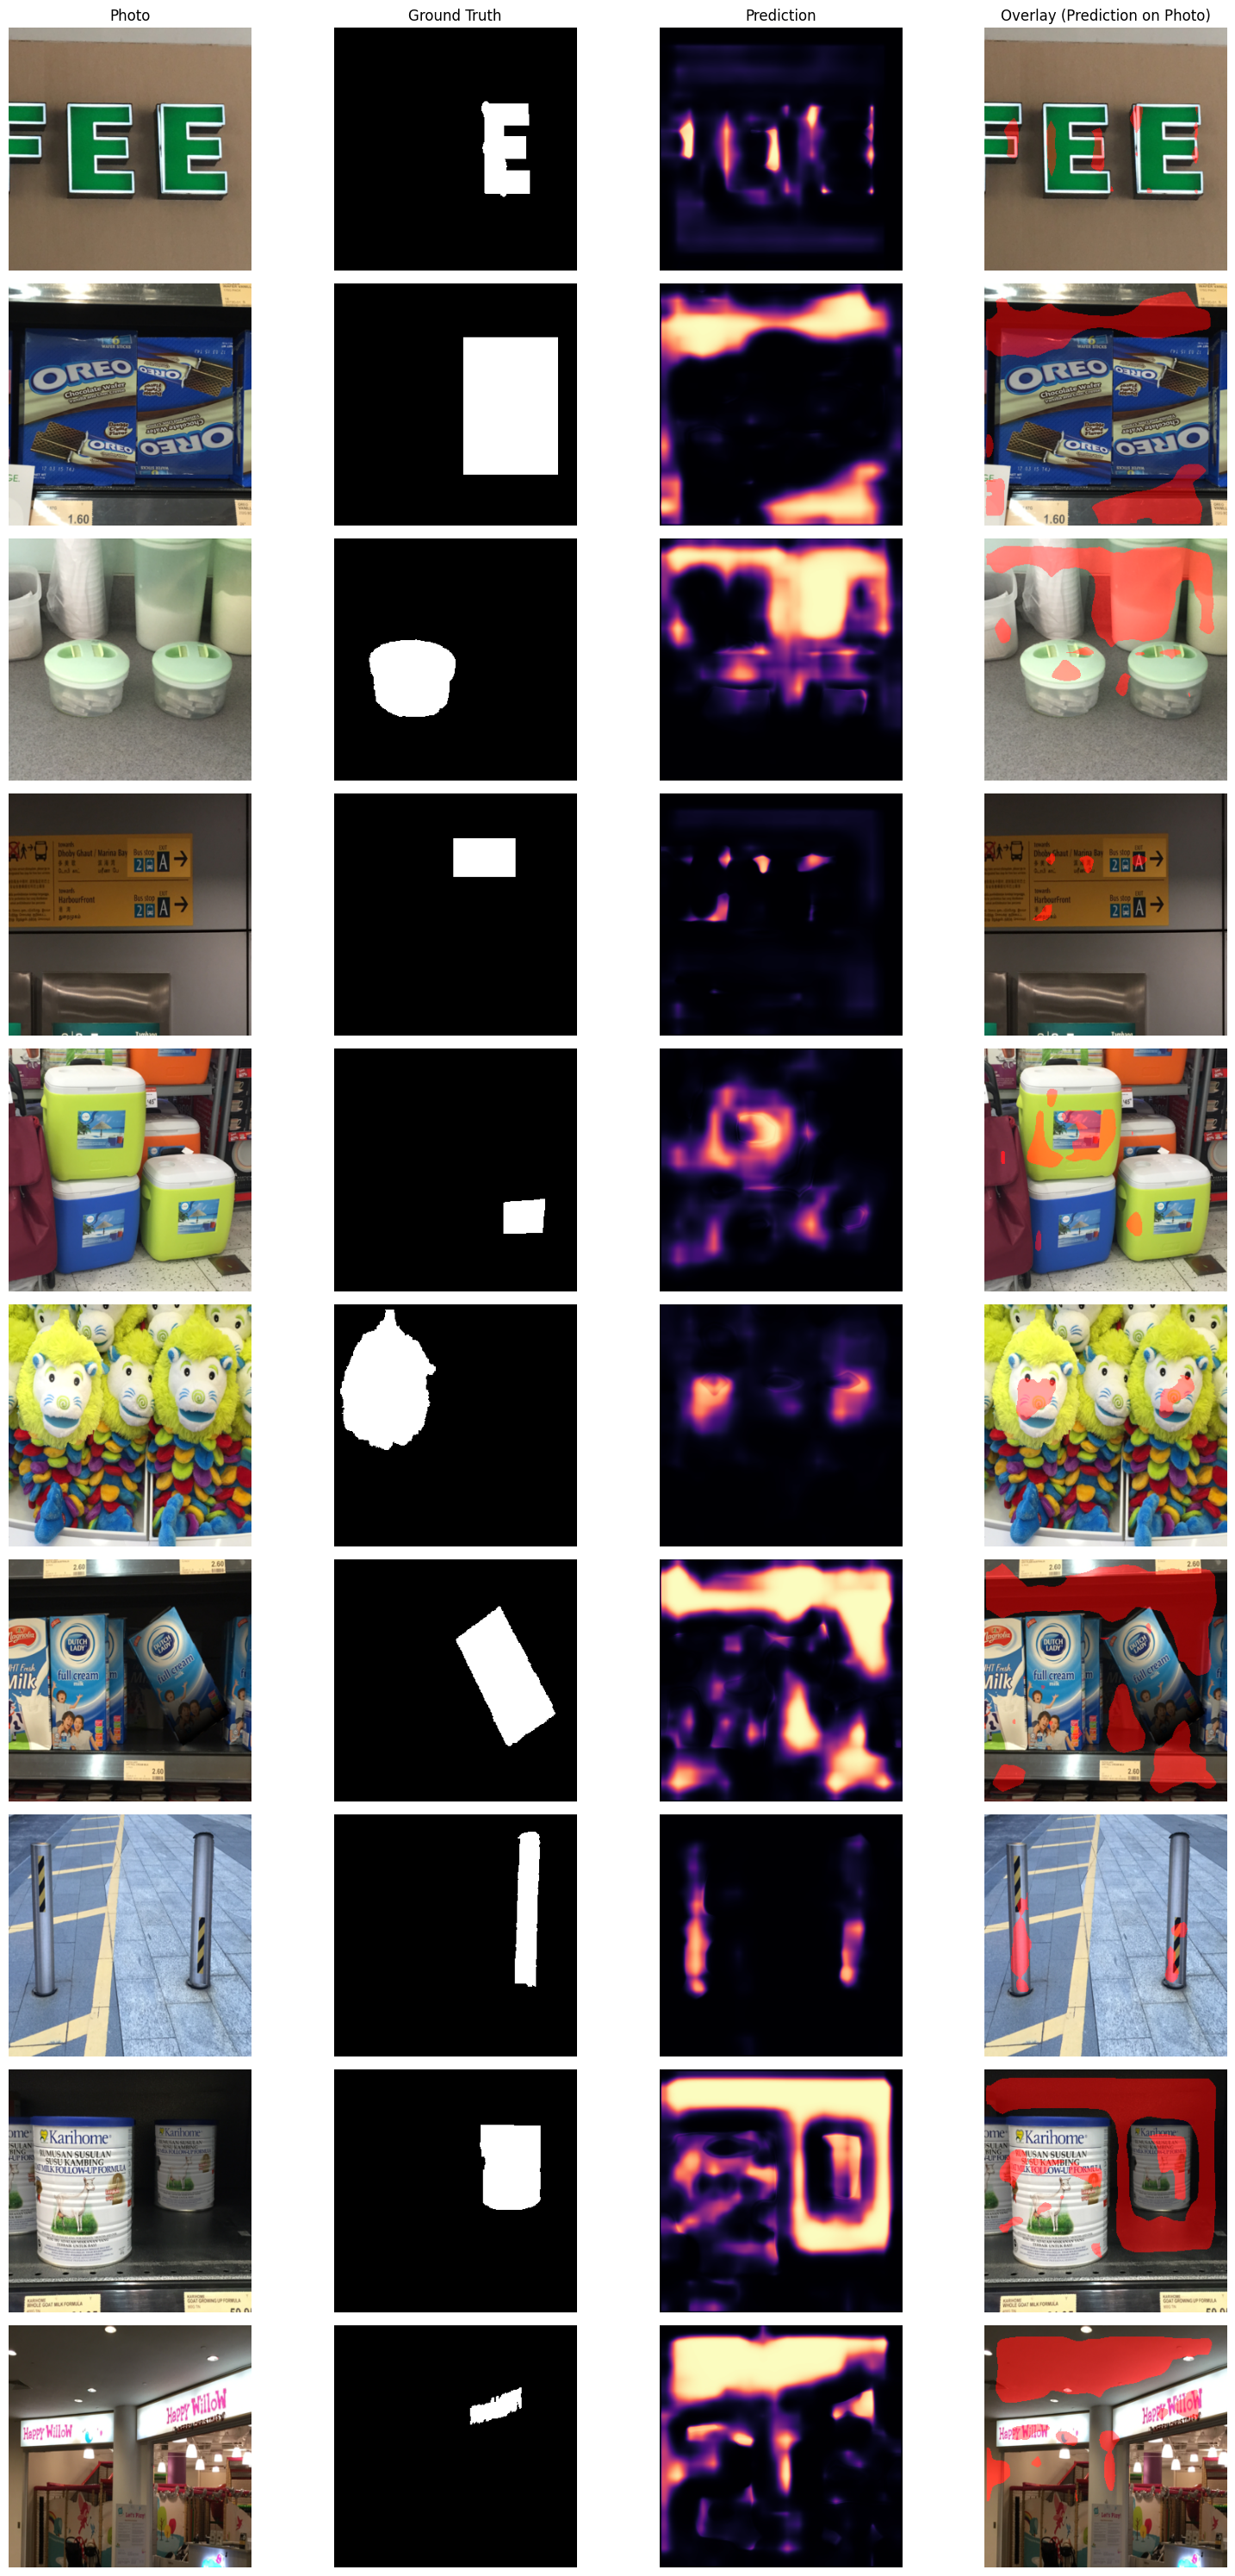

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from pathlib import Path

manifest = load_manifest(MANIFEST_PATH)
test_samples = [s for s in manifest.samples if s.split == "test"]
if not test_samples:
    raise RuntimeError("No samples found in test split")

# Keep only fake/manipulated test samples (label==1; fallback to mask presence)
fake_test_samples = [s for s in test_samples if getattr(s, "label", 0) == 1 or s.mask_path is not None]
if not fake_test_samples:
    raise RuntimeError("No fake samples found in test split")

samples_to_show = fake_test_samples[:10]
print(f"Showing {len(samples_to_show)} fake samples from test split")

# Build a one-time tar index for robust path remapping
tar_files = []
for pat in ("*.tar", "*.tar.gz", "*.tgz"):
    tar_files.extend(DATA_DIR.rglob(pat))
tar_by_name = {}
for t in tar_files:
    tar_by_name.setdefault(t.name, []).append(t)

def _norm(value: str) -> str:
    return str(value).replace('\\', '/')

def _suffix_score(a_parts, b_parts):
    score = 0
    for ax, bx in zip(reversed(a_parts), reversed(b_parts)):
        if ax != bx:
            break
        score += 1
    return score

def _candidate_paths(value: str):
    normalized = _norm(value)
    p = Path(normalized)
    manifest_parent = Path(MANIFEST_PATH).parent
    candidates = []

    if p.is_absolute():
        candidates.append(p)
    else:
        candidates.extend([
            manifest_parent / p,
            DATA_DIR / p,
            DATA_DIR / "ngiml" / p,
            Path("/content") / p,
            Path("/content/data") / p,
            Path("/content/ngiml") / p,
        ])

    if "prepared/" in normalized:
        suffix = normalized.split("prepared/", 1)[1]
        candidates.extend([
            DATA_DIR / "prepared" / suffix,
            DATA_DIR / "ngiml" / "prepared" / suffix,
            Path("/content") / "prepared" / suffix,
            Path("/content/ngiml") / "prepared" / suffix,
        ])

    seen = set()
    unique = []
    for cand in candidates:
        key = cand.as_posix()
        if key not in seen:
            seen.add(key)
            unique.append(cand)
    return unique

def _match_tar_by_basename(value: str):
    name = Path(_norm(value)).name
    matches = tar_by_name.get(name, [])
    if not matches:
        return None
    hint_parts = Path(_norm(value)).parts
    return max(matches, key=lambda p: _suffix_score(p.parts, hint_parts))

def _resolve_file(value: str) -> Path:
    candidates = _candidate_paths(value)
    for cand in candidates:
        if cand.exists():
            return cand

    if str(value).endswith((".tar", ".tar.gz", ".tgz")):
        tar_match = _match_tar_by_basename(value)
        if tar_match is not None:
            return tar_match

    return candidates[0] if candidates else Path(_norm(value))

def _resolve_path(path_str):
    if path_str is None:
        return None
    normalized = _norm(path_str)
    if "::" in normalized:
        archive, member = normalized.split("::", 1)
        archive_path = _resolve_file(archive).as_posix()
        member_path = _norm(member)
        return f"{archive_path}::{member_path}"
    return _resolve_file(normalized).as_posix()

def _load_image_and_mask(record):
    image_path = _resolve_path(record.image_path)
    if '::' in image_path and image_path.endswith('.npz'):
        image, mask, _ = _load_from_tar_npz(image_path)
    elif image_path.endswith('.npz'):
        image, mask, _ = _load_from_npz(image_path)
    else:
        image = _load_image(image_path)
        mask = None
        if record.mask_path is not None:
            mask_path = _resolve_path(record.mask_path)
            mask = _load_image(mask_path)

    image = image.float()
    if image.max() > 1.0:
        image = image / 255.0

    if mask is None:
        mask = torch.zeros((1, image.shape[-2], image.shape[-1]), dtype=torch.float32)
    else:
        mask = mask.float()
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)
        if mask.shape[0] > 1:
            mask = mask[:1]
        if mask.max() > 1.0:
            mask = mask / 255.0
        if tuple(mask.shape[-2:]) != tuple(image.shape[-2:]):
            mask = F.interpolate(mask.unsqueeze(0), size=image.shape[-2:], mode='nearest').squeeze(0)

    return image, mask

rows = len(samples_to_show)
fig, axes = plt.subplots(rows, 4, figsize=(16, 3 * rows))
if rows == 1:
    axes = np.expand_dims(axes, axis=0)

col_titles = ["Photo", "Ground Truth", "Prediction", "Overlay (Prediction on Photo)"]
for col, title in enumerate(col_titles):
    axes[0, col].set_title(title)

for i, sample in enumerate(samples_to_show):
    image, gt_mask = _load_image_and_mask(sample)

    x = image.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x, target_size=image.shape[-2:])[-1]
        pred_prob = torch.sigmoid(logits)[0, 0].detach().cpu()

    img_np = image.permute(1, 2, 0).cpu().numpy()
    gt_np = gt_mask[0].cpu().numpy()
    pred_np = pred_prob.numpy()

    pred_bin = (pred_np >= 0.5).astype(np.float32)
    overlay = img_np.copy()
    overlay[..., 0] = np.clip(overlay[..., 0] + 0.5 * pred_bin, 0, 1)
    overlay[..., 1] = np.clip(overlay[..., 1] * (1.0 - 0.35 * pred_bin), 0, 1)
    overlay[..., 2] = np.clip(overlay[..., 2] * (1.0 - 0.35 * pred_bin), 0, 1)

    axes[i, 0].imshow(img_np)
    axes[i, 1].imshow(gt_np, cmap='gray', vmin=0, vmax=1)
    axes[i, 2].imshow(pred_np, cmap='magma', vmin=0, vmax=1)
    axes[i, 3].imshow(overlay)

    for j in range(4):
        axes[i, j].axis('off')

    axes[i, 0].set_ylabel(f"{sample.dataset}\n#{i+1}", rotation=0, labelpad=28, va='center')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
from PIL import Image
import io
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")

filename, file_bytes = next(iter(uploaded.items()))
pil_img = Image.open(io.BytesIO(file_bytes)).convert("RGB")
img_np = np.array(pil_img).astype(np.float32) / 255.0
img = torch.from_numpy(img_np).permute(2, 0, 1)

# Ensure spatial size is compatible with Swin/decoder (multiple of 32)
h, w = img.shape[-2], img.shape[-1]

# --- Start of added code for OOM fix ---
MAX_SIDE_LENGTH = 768 # You can adjust this value if still getting OOM
if max(h, w) > MAX_SIDE_LENGTH:
    scale_factor = MAX_SIDE_LENGTH / max(h, w)
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
else:
    new_h, new_w = h, w

target_h = int(math.ceil(new_h / 32) * 32)
target_w = int(math.ceil(new_w / 32) * 32)
# --- End of added code for OOM fix ---

# Original resizing logic, now using target_h, target_w from OOM fix
if (target_h, target_w) != (h, w):
    img = F.interpolate(img.unsqueeze(0), size=(target_h, target_w), mode="bilinear", align_corners=False).squeeze(0)

x = img.unsqueeze(0).to(device)
with torch.no_grad():
    logits = model(x, target_size=img.shape[-2:])[-1]
    pred_prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()

img_show = img.permute(1, 2, 0).cpu().numpy()
pred_bin = (pred_prob >= 0.5).astype(np.float32)

overlay = img_show.copy()
overlay[..., 0] = np.clip(overlay[..., 0] + 0.5 * pred_bin, 0, 1)
overlay[..., 1] = np.clip(overlay[..., 1] * (1.0 - 0.35 * pred_bin), 0, 1)
overlay[..., 2] = np.clip(overlay[..., 2] * (1.0 - 0.35 * pred_bin), 0, 1)

print(f"Uploaded: {filename}")
print("Input tensor shape:", tuple(x.shape))
print("Prediction stats min/mean/max:", float(pred_prob.min()), float(pred_prob.mean()), float(pred_prob.max()))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Uploaded Photo")
plt.imshow(img_show)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Prediction")
plt.imshow(pred_prob, cmap="magma", vmin=0, vmax=1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
# Model complexity stats (params, FLOPs, MACs)
from tools.local_infer_helpers import get_model_complexity_stats

def _human(n: float | int | None) -> str:
    if n is None:
        return "n/a"
    n = float(n)
    if n >= 1e12:
        return f"{n/1e12:.3f}T"
    if n >= 1e9:
        return f"{n/1e9:.3f}B"
    if n >= 1e6:
        return f"{n/1e6:.3f}M"
    if n >= 1e3:
        return f"{n/1e3:.3f}K"
    return f"{n:.0f}"

# Keep aligned with your training/inference resolution.
PROFILE_INPUT_SIZE = (1, 3, 320, 320)
stats = get_model_complexity_stats(model, input_size=PROFILE_INPUT_SIZE)

print("Model complexity:")
print({
    "input_size": stats["input_size"],
    "total_params": f"{stats['total_params']:,} ({_human(stats['total_params'])})",
    "trainable_params": f"{stats['trainable_params']:,} ({_human(stats['trainable_params'])})",
    "frozen_params": f"{stats['frozen_params']:,} ({_human(stats['frozen_params'])})",
    "flops": f"{_human(stats['flops'])}" if stats.get("flops") is not None else "n/a",
    "macs": f"{_human(stats['macs'])}" if stats.get("macs") is not None else "n/a",
})
if stats.get("flops_error"):
    print("FLOPs note:", stats["flops_error"])